# 라이브러리 임포트

In [27]:
import sys
# 예제 파일 경로로 수정한 다음 주석 해제
# sys.path.append(r'/to/your/example_code/path/lincoln')

In [28]:
# imports
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.pytorch.layers import PyTorchLayer, DenseLayer
from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor
from lincoln.pytorch.utils import assert_dim, permute_data

torch.manual_seed(20190325);

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 주택가격 데이터셋

In [30]:
from sklearn.datasets import load_boston

boston = load_boston()

data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

## 주택가격 예측 모델 정의

In [31]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size, 
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:
        
        assert_dim(x, 2)
        
        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),

## 학습률 감쇠 구현

In [32]:
# model, optimizer, loss
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
optimizer = optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)

In [33]:
criterion = nn.MSELoss()

In [34]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion)

trainer.fit(X_train=X_train, 
            y_train=y_train, 
            X_test=X_test, 
            y_test=y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)

/home/flourscent/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


1  에폭 학습한 후의 손실은  437.97467041015625
11  에폭 학습한 후의 손실은  27.093313217163086
21  에폭 학습한 후의 손실은  19.90015411376953
31  에폭 학습한 후의 손실은  22.189697265625
41  에폭 학습한 후의 손실은  17.994813919067383
51  에폭 학습한 후의 손실은  18.32546615600586
61  에폭 학습한 후의 손실은  16.955612182617188
71  에폭 학습한 후의 손실은  17.67221450805664
81  에폭 학습한 후의 손실은  16.66954231262207
91  에폭 학습한 후의 손실은  15.831522941589355


In [35]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

14.367990493774414

In [36]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test

In [37]:
test_pred = test_pred.detach().numpy()
test_actual = test_actual.detach().numpy()

## 주택 가격 데이터 - 데이터 탐색

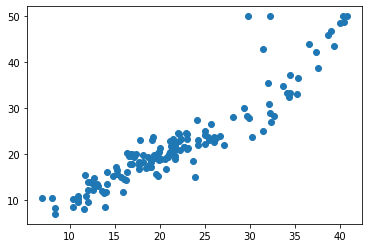

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(test_pred, test_actual)

# 파이토치로 CNN 구현하기

`DataLoader`를 사용한 예와 사용하지 않은 예의 순서대로 살펴보자.

In [39]:
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1305,), (0.3081,))
])

In [40]:
# https://pytorch.org/docs/stable/data.html
train_dataset = MNIST(root='../mnist_data/',
                      train=True, 
                      download=True,
                      transform=img_transforms)

test_dataset = MNIST(root='../mnist_data/',
                     train=False, 
                     download=True,
                     transform=img_transforms)

In [41]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=60, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=60, 
                                           shuffle=False)

In [42]:
class ConvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, filter_size, 
                              padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

In [43]:
class MNIST_ConvNet(PyTorchModel):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh(),
                               dropout=0.8)
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True,
                               dropout=0.8)
        self.dense1 = DenseLayer(28 * 28 * 7, 32, activation=nn.Tanh(),
                                 dropout=0.8)
        self.dense2 = DenseLayer(32, 10)

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.dense1(x)
        x = self.dense2(x)
        return x,

In [44]:
model = MNIST_ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### `Dataloader`를 사용한 경우

In [45]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(train_dataloader = train_loader,        
            test_dataloader = test_loader,
            epochs = 1,
            eval_every = 1)

0  에폭 학습한 후의 손실은  0.0981


## `DataLoader`를 사용했을 때 정확도

In [46]:
def test_accuracy(model):
    model.eval()
    accuracies = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)[0]
        accuracy_batch = (torch.max(output, dim=1)[1] == y_batch).type(torch.float32).mean().item()
        accuracies.append(accuracy_batch)
    return torch.Tensor(accuracies).mean().item()

In [47]:
test_accuracy(model)

0.970059871673584

## `DataLoader`를 사용하지 않은 경우

### 전처리

In [48]:
mnist_train = ((train_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081
mnist_test = ((test_dataset.data.type(torch.float32).unsqueeze(3).permute(0, 3, 1, 2) / 255.0) - 0.1305) / 0.3081

In [49]:
mnist_train.min(), mnist_train.max(), mnist_test.min(), mnist_test.max()

(tensor(-0.4236), tensor(2.8221), tensor(-0.4236), tensor(2.8221))

### 학습

In [50]:
trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train=mnist_train, y_train=train_dataset.targets, 
            X_test=mnist_test, y_test=test_dataset.targets,     
            epochs=1,
            eval_every=1)

1  에폭 학습한 후의 손실은  0.08260177075862885


### 성능 측정

In [51]:
def test_accuracy_no_dataloader(model, mnist_test):
    model.eval()
    output = model(mnist_test)[0]
    return (torch.max(output, dim=1)[1] == test_dataset.test_labels).type(torch.float32).mean().item()

In [52]:
test_accuracy_no_dataloader(model, mnist_test)

/home/flourscent/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


0.9753999710083008

~97.3% 정확도

# LSTM

## `LSTMLayer`

In [53]:
class LSTMLayer(PyTorchLayer):
    def __init__(self,
                 sequence_length: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 dropout: float = 1.0) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.h_init = torch.zeros((1, hidden_size))
        self.c_init = torch.zeros((1, hidden_size))
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = DenseLayer(hidden_size, output_size)
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

        
    def _transform_hidden_batch(self, hidden: Tensor,
                                batch_size: int,
                                before_layer: bool) -> Tensor:
        
        if before_layer:
            return (hidden
                    .repeat(batch_size, 1)
                    .view(batch_size, 1, self.hidden_size)
                    .permute(1,0,2))
        else:
            return (hidden
                    .permute(1,0,2)
                    .mean(dim=0))         
    

    def forward(self, x: Tensor) -> Tensor:
        
        batch_size = x.shape[0]

        h_layer = self._transform_hidden_batch(self.h_init, batch_size, before_layer=True)
        c_layer = self._transform_hidden_batch(self.c_init, batch_size, before_layer=True)
        
        x, (h_out, c_out) = self.lstm(x, (h_layer, c_layer))
        
        self.h_init, self.c_init = (
            self._transform_hidden_batch(h_out, batch_size, before_layer=False).detach(),
            self._transform_hidden_batch(c_out, batch_size, before_layer=False).detach()
        )

        x = self.fc(x)
        if hasattr(self, "dropout"):
            x = self.dropout(x) 
            
        return x

In [54]:
lay = LSTMLayer(sequence_length=25,
          input_size=62,
          hidden_size=100,
          output_size=128)

x = torch.randn(32, 25, 62)

lay(x).shape

torch.Size([32, 25, 128])

## `NextCharacterModel`

In [55]:
class NextCharacterModel(PyTorchModel):
    def __init__(self,
                 vocab_size: int,
                 hidden_size: int = 256,
                 sequence_length: int = 25):
        super().__init__()
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        
        # 이 모델에는 층이 하나 뿐이며
        # 이 층의 출력은 입력과 모양이 같다
        self.lstm = LSTMLayer(self.sequence_length, self.vocab_size, hidden_size, self.vocab_size)

    def forward(self,
                inputs: Tensor):
        assert_dim(inputs, 3) # batch_size, sequence_length, vocab_size

        out = self.lstm(inputs)       
        
        return out.permute(0, 2, 1),

## `LSTMTrainer`

In [56]:
class LSTMTrainer(PyTorchTrainer):
    def __init__(self,
                 model: NextCharacterModel,
                 optim: Optimizer,
                 criterion: _Loss):
        super().__init__(model, optim, criterion)
        self.vocab_size = self.model.vocab_size
        self.max_len = self.model.sequence_length
        
    def fit(self,
            data: str,
            epochs: int=10,
            eval_every: int=1,
            batch_size: int=32,
            seed: int = 121718)-> None:
        
        self.data = data
        self.train_data, self.test_data = self._train_test_split_text()
        self.chars = list(set(self.data))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

        torch.manual_seed(seed)

        losses = deque(maxlen=50)
        
        for e in range(epochs):

            batch_generator = self.generate_batches_next_char(batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.optim.zero_grad()                
                outputs = self.model(X_batch)[0]

                loss = self.loss(outputs, y_batch)
                losses.append(loss.item())

                loss.backward()
                
                self.optim.step()    

            if (e+1) % eval_every == 0:

                X_test, y_test = self.generate_test_data()
            
                test_preds = self.model.forward(X_test)[0]

                loss = self.loss.forward(test_preds, y_test)
                print(f"{e+1}에폭에서 검증 데이터에 대한 손실값: {loss.item():.3f}")

    def _train_test_split_text(self, pct=0.8) -> Tuple[str]:

        n = len(self.data)
        return self.data[:int(n * pct)], self.data[int(n * pct):]

    def generate_batches_next_char(self,
                                   batch_size: int) -> Tuple[Tensor]:
        N = len(self.train_data)
        # add batch size
        for ii in range(0, N, batch_size):

            features_tensors = []
            target_indices = []

            for char in range(batch_size):

                features_str, target_str =\
                 self.train_data[ii+char:ii+char+self.max_len],\
                 self.train_data[ii+char+1:ii+char+self.max_len+1]

                features_array = self._string_to_one_hot_array(features_str)
                target_indices_seq = [self.char_to_idx[char] for char in target_str]

                features_tensors.append(features_array)
                target_indices.append(target_indices_seq)
            if len(features_str) != len(target_str):
                break
            yield torch.stack(features_tensors), torch.LongTensor(target_indices)

    def _string_to_one_hot_array(self, input_string: str) -> Tuple[Tensor]:

        ind = [self.char_to_idx[ch] for ch in input_string]

        array = self._one_hot_text_data(ind)

        return array

    def _one_hot_text_data(self,
                           sequence: List):

        sequence_length = len(sequence)
        batch = torch.zeros(sequence_length, self.vocab_size)
        for i in range(sequence_length):
            batch[i, sequence[i]] = 1.0

        return Tensor(batch)

    def generate_test_data(self) -> Tuple[Tensor]:

        features_str, target_str = self.test_data[:-1], self.test_data[1:]

        X_tensors = []
        y_tensors = []

        N = len(self.test_data)

        for start in range(0, N, self.max_len):

            features_str, target_str =\
                self.test_data[start:start+self.max_len],\
                self.test_data[start+1:start+self.max_len+1]

            if len(features_str) != len(target_str):
                break
            features_array = self._string_to_one_hot_array(features_str)
            target_indices_seq = [self.char_to_idx[char] for char in target_str]

            X_tensors.append(features_array)
            y_tensors.append(torch.LongTensor(target_indices_seq))
            
        return torch.stack(X_tensors), torch.stack(y_tensors)


In [60]:
#data = open('data/input.txt', 'r').read()
data = open('../06_rnns/input.txt', 'r').read()
vocab_size = len(set(data))
model = NextCharacterModel(vocab_size, hidden_size=vocab_size, sequence_length=50)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [61]:
lstm_trainer = LSTMTrainer(model, optimizer, criterion)

In [62]:
lstm_trainer.fit(data, epochs=1)

1에폭에서 검증 데이터에 대한 손실값: 2.319


# 오토인코더를 활용한 비지도 학습

## `DeconvLayer`

In [63]:
class DeconvLayer(PyTorchLayer):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 filter_size: int,
                 activation: nn.Module = None,
                 dropout: float = 1.0,
                 flatten: bool = False) -> None:
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, filter_size, 
                                       padding=filter_size // 2)
        self.activation = activation
        self.flatten = flatten
        if dropout < 1.0:
            self.dropout = nn.Dropout(1 - dropout)

    def forward(self, x: Tensor) -> Tensor:

        x = self.deconv(x)
        if self.activation:
            x = self.activation(x)
        if self.flatten:
            x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        if hasattr(self, "dropout"):
            x = self.dropout(x)            
            
        return x

## `Autoencoder`

In [64]:
class Autoencoder(PyTorchModel):
    def __init__(self,
                 hidden_dim: int = 28):
        super(Autoencoder, self).__init__()
        self.conv1 = ConvLayer(1, 14, 5, activation=nn.Tanh())
        self.conv2 = ConvLayer(14, 7, 5, activation=nn.Tanh(), flatten=True)
        
        self.dense1 = DenseLayer(7 * 28 * 28, hidden_dim, activation=nn.Tanh())
        self.dense2 = DenseLayer(hidden_dim, 7 * 28 * 28, activation=nn.Tanh())
        
        self.conv3 = ConvLayer(7, 14, 5, activation=nn.Tanh()) 
        self.conv4 = ConvLayer(14, 1, 5, activation=nn.Tanh())         

    def forward(self, x: Tensor) -> Tensor:
        assert_dim(x, 4)
            
        x = self.conv1(x)
        x = self.conv2(x)
#         import pdb; pdb.set_trace()
        encoding = self.dense1(x)
        
        x = self.dense2(encoding)
        
        x = x.view(-1, 7, 28, 28)
        
        x = self.conv3(x)
        x = self.conv4(x)

        return x, encoding

## 데이터 전처리

In [65]:
X_train = mnist_train
X_test = mnist_test

In [66]:
X_train_auto = (X_train - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1
X_test_auto = (X_test - X_train.min()) / (X_train.max() - X_train.min()) * 2 - 1

In [67]:
model = Autoencoder()

In [68]:
model = Autoencoder(hidden_dim=28)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

trainer = PyTorchTrainer(model, optimizer, criterion)

trainer.fit(X_train_auto, X_train_auto,
            X_test_auto, X_test_auto,
            epochs=1,
            batch_size=60)

1  에폭 학습한 후의 손실은  0.06928978115320206


In [69]:
reconstructed_images, image_representations = model(X_test_auto)

In [76]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

# matplotlib 폰트설정
#plt.rc('font', family='NanumGothicOTF') # For MacOS
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])

['NanumGothic']


In [71]:
def display_image(ax,
    t: Tensor):
    n = t.detach().numpy()
    ax.imshow(n.reshape(28, 28))

In [72]:
np.random.seed(20190504)
a = np.random.randint(0, 10000)

In [73]:
X_test[a].shape

torch.Size([1, 28, 28])

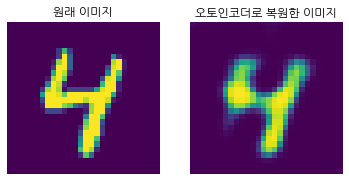

In [77]:
f, axarr = plt.subplots(1,2)
display_image(axarr[0], X_test[a])
display_image(axarr[1], reconstructed_images[a])

axarr[0].set_title("원래 이미지")
axarr[1].set_title("오토인코더로 복원한 이미지")

axarr[0].axis('off')
axarr[1].axis('off');

# f.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/03_autoencoder_example_image.png")

# t-SNE를 이용한 시각화

In [78]:
from sklearn.manifold import TSNE
tsne_result = TSNE(n_components=2, random_state=20190405).fit_transform(image_representations.detach().numpy())

## 시각화

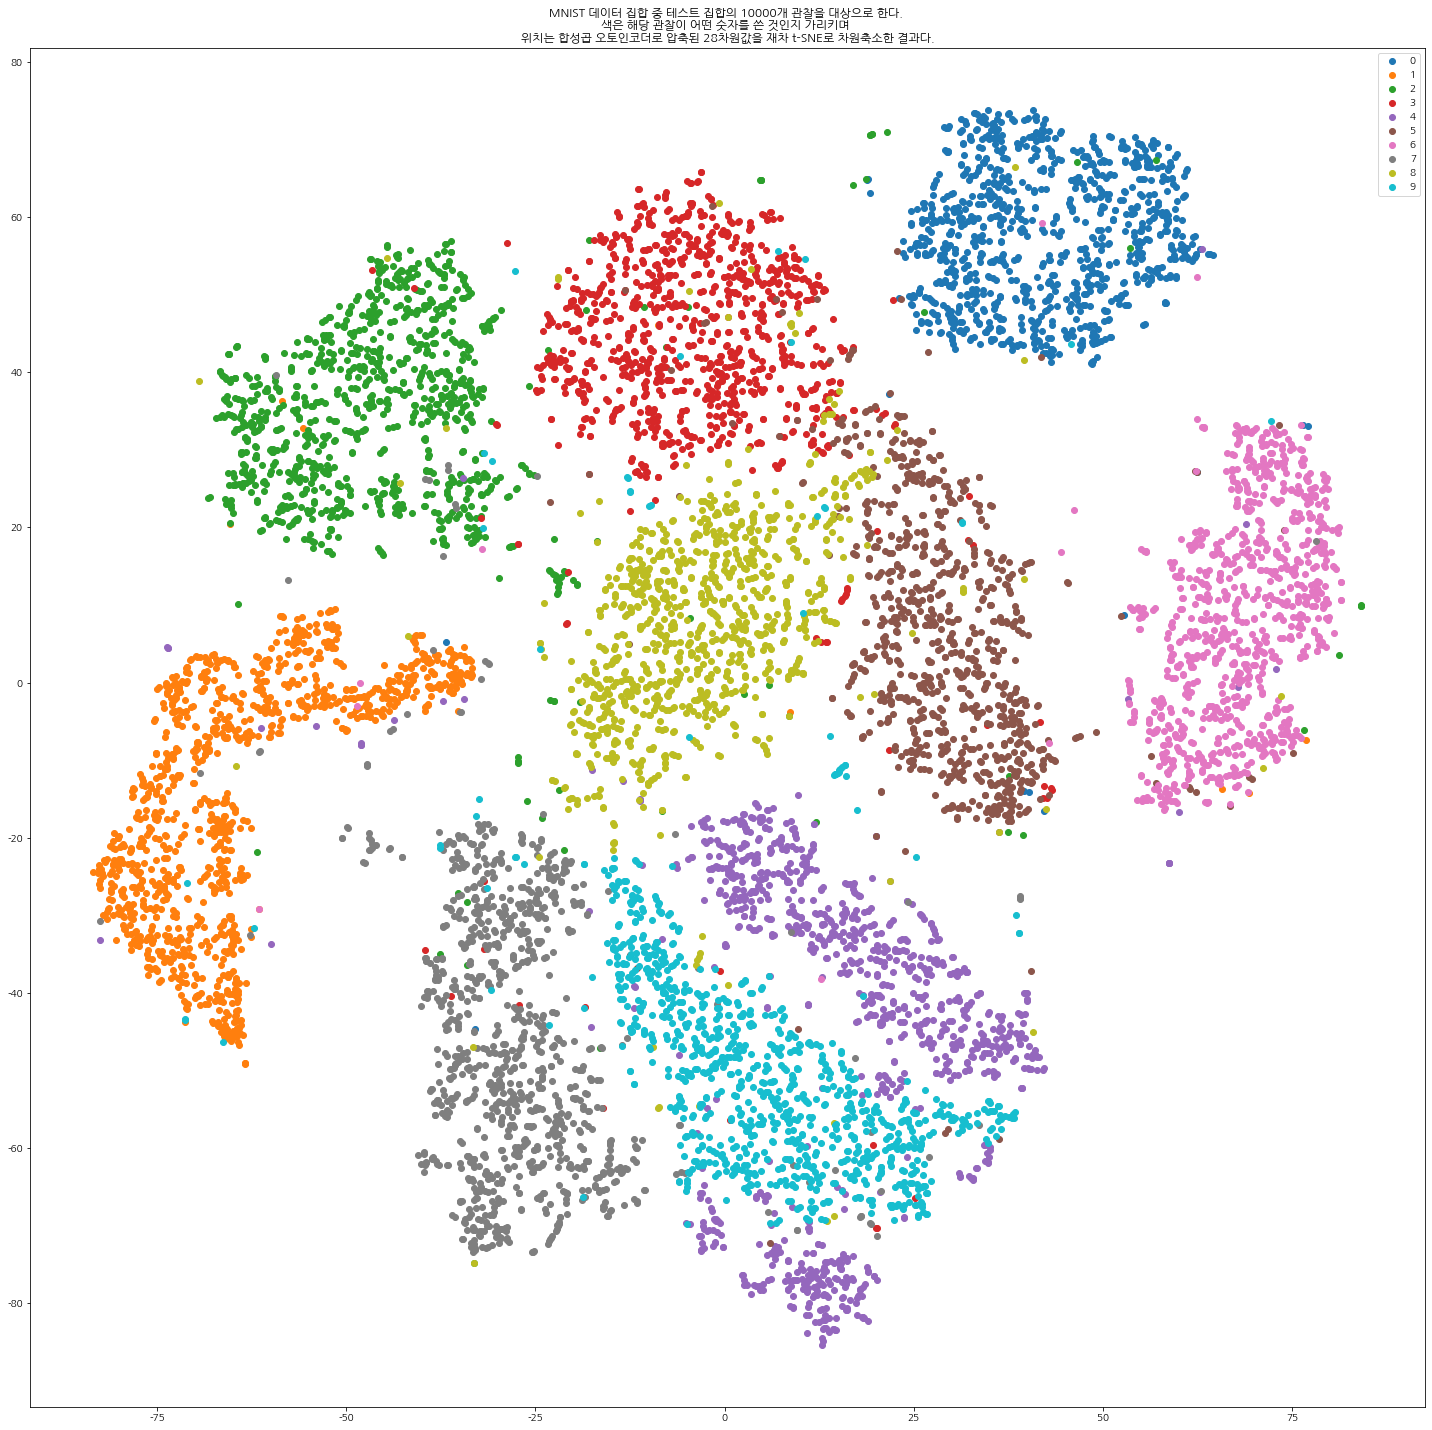

In [79]:
import pandas as pd
tsne_df = pd.DataFrame({'tsne_dim_1': tsne_result[:,0],
              'tsne_dim_2': tsne_result[:,1],
              'category': test_dataset.targets})
groups = tsne_df.groupby('category')

# Plot
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title('''MNIST 데이터 집합 중 테스트 집합의 10000개 관찰을 대상으로 한다. 
색은 해당 관찰이 어떤 숫자를 쓴 것인지 가리키며 
위치는 합성곱 오토인코더로 압축된 28차원값을 재차 t-SNE로 차원축소한 결과다.''')
ax.margins(0.05) # 자동 스케일링을 위한 5% 패딩 추가
for name, group in groups:
    ax.scatter(group['tsne_dim_1'], group['tsne_dim_2'], marker='o', label=name)
ax.legend();
# fig.savefig("../../01_deep-learning-from-scratch/images/07_pytorch/00_tsne.png")